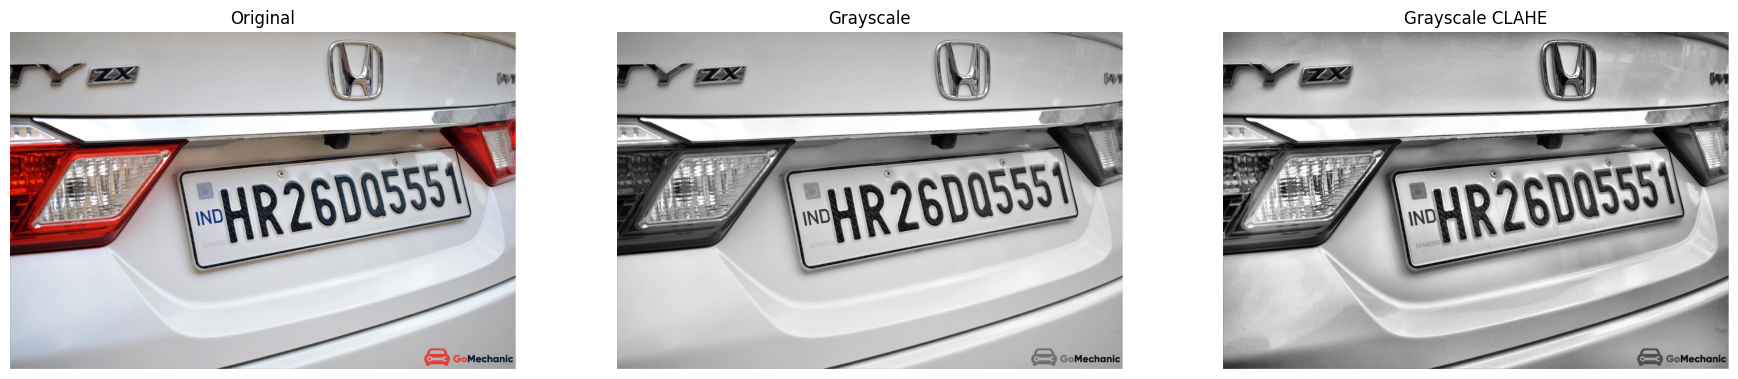

In [165]:
import cv2
import matplotlib.pyplot as plt

# Baca gambar
img = cv2.imread("car08.jpg")

# Konversi ke RGB (karena OpenCV default-nya BGR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#gray2 = cv2.equalizeHist(gray)

# Contoh peningkatan CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
gray2 = clahe.apply(gray) # Terapkan pada gambar grayscale asli


# Tampilkan
plt.figure(figsize=(30,10))

plt.subplot(1,4,1)
plt.title("Original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Grayscale")
plt.imshow(gray, cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Grayscale CLAHE")
plt.imshow(gray2, cmap="gray")
plt.axis("off")



plt.show()


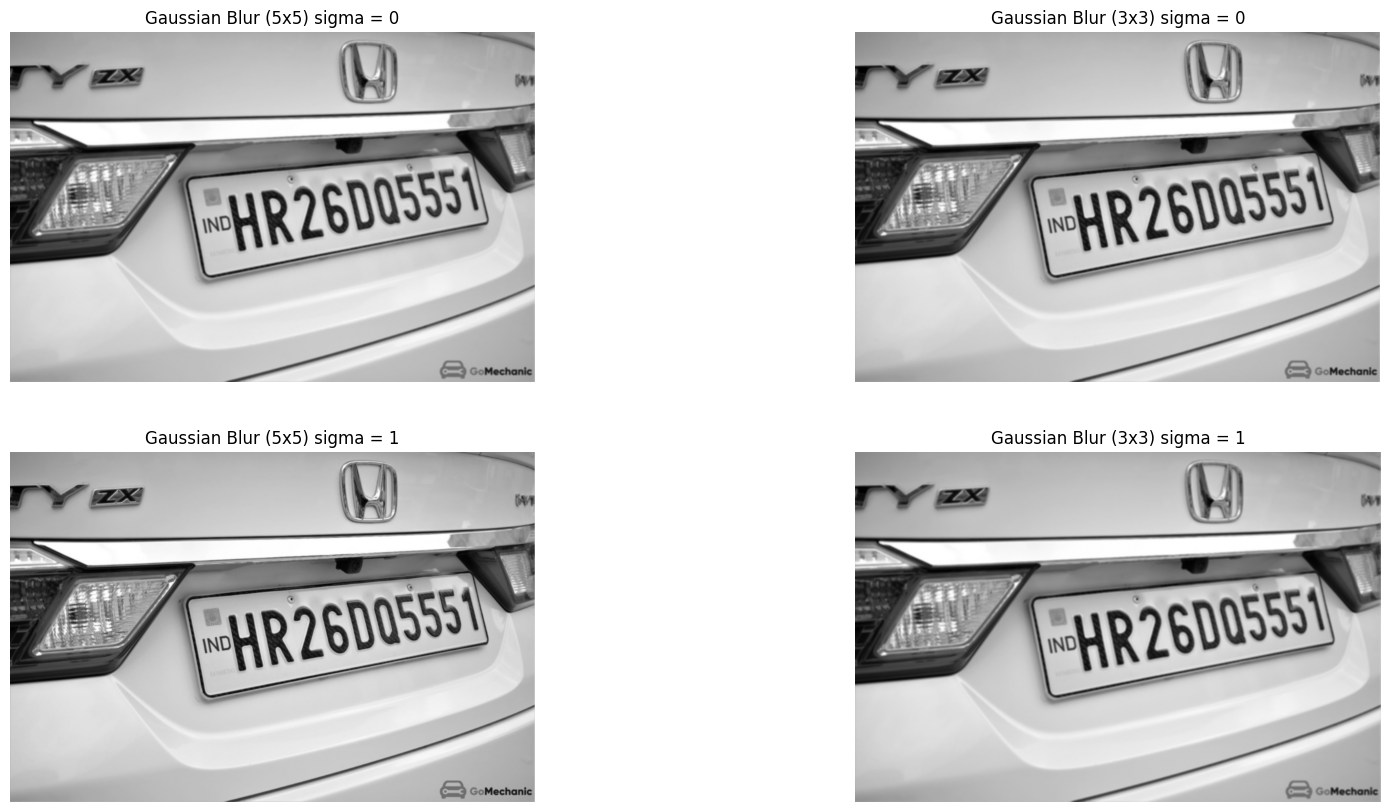

In [166]:
# Gaussian Blur
blur5x5_0 = cv2.GaussianBlur(gray, (7, 7), 2)  # kernel 5x5
blur3x3_0 = cv2.GaussianBlur(gray, (9, 9), 0)  # kernel 3x3
blur5x5_1 = cv2.GaussianBlur(gray, (5, 5), 1)  # kernel 5x5
blur3x3_1 = cv2.GaussianBlur(gray, (7, 7), 2.8)  # kernel 3x3

# Tampilkan hasil
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.title("Gaussian Blur (5x5) sigma = 0")
plt.imshow(blur5x5_0, cmap="gray")
plt.axis("off")

plt.subplot(2,2,2)
plt.title("Gaussian Blur (3x3) sigma = 0")
plt.imshow(blur3x3_0, cmap="gray")
plt.axis("off")

plt.subplot(2,2,3)
plt.title("Gaussian Blur (5x5) sigma = 1")
plt.imshow(blur5x5_1, cmap="gray")
plt.axis("off")

plt.subplot(2,2,4)
plt.title("Gaussian Blur (3x3) sigma = 1")
plt.imshow(blur3x3_1, cmap="gray")
plt.axis("off")

plt.show()

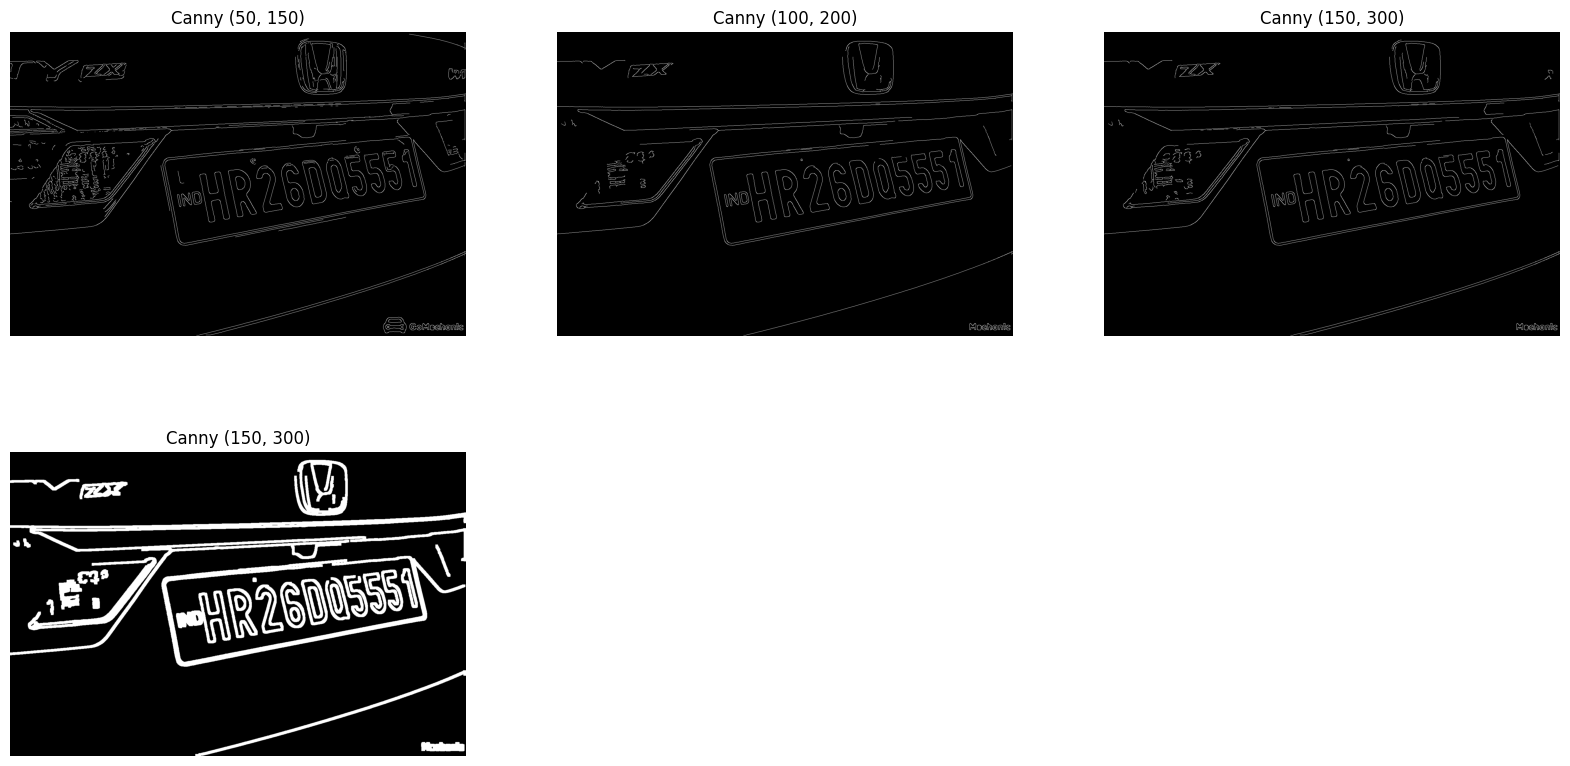

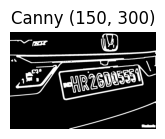

In [167]:
import numpy as np

blur = blur3x3_1

edges1 = cv2.Canny(blur, 70, 100)
edges2 = cv2.Canny(blur, 70, 210)
edges3 = cv2.Canny(blur, 70, 180)

kernel_close = np.ones((5,5), np.uint8) 
dilated_edges = cv2.dilate(edges2, kernel_close, iterations=2)

closed_edges = cv2.morphologyEx(dilated_edges, cv2.MORPH_CLOSE, kernel_close)

#invert = 255 - edges2

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.title("Canny (50, 150)")
plt.imshow(edges1, cmap="gray")
plt.axis("off")

plt.subplot(2,3,2)
plt.title("Canny (100, 200)")
plt.imshow(edges2, cmap="gray")
plt.axis("off")

plt.subplot(2,3,3)
plt.title("Canny (150, 300)")
plt.imshow(edges3, cmap="gray")
plt.axis("off")

plt.subplot(2,3,4)
plt.title("Canny (150, 300)")
plt.imshow(dilated_edges, cmap="gray")
plt.axis("off")
plt.show()

plt.subplot(2,3,5)
plt.title("Canny (150, 300)")
plt.imshow(closed_edges, cmap="gray")
plt.axis("off")
plt.show()

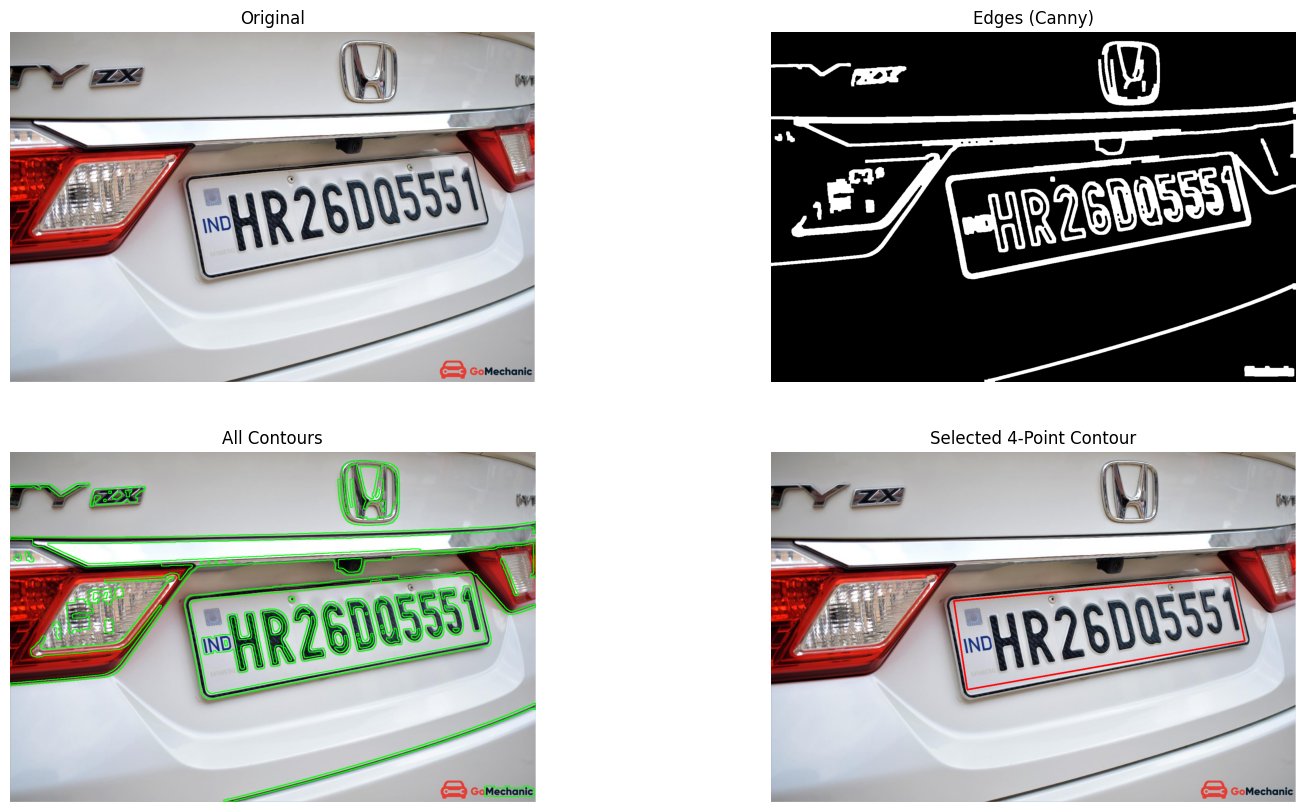

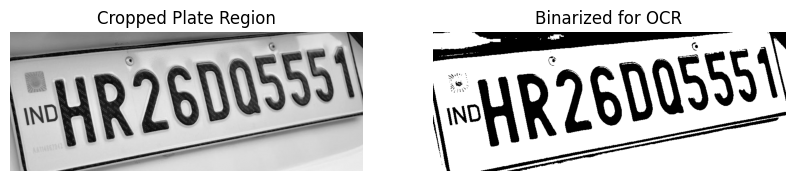


--- HASIL OCR ---
Teks Plat Nomor Terdeteksi: ARDEUUSSS


In [168]:
# Convert edges to 8-bit image
# Note: cv2.findContours bisa menerima closed_edges.copy() secara langsung 
# jika sudah dijamin uint8 dan memiliki nilai 0 atau 255 (hasil morfologi)
edges_for_contour = closed_edges.copy() 

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges_for_contour, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours based on area, largest first
cont = sorted(contours, key=cv2.contourArea, reverse=True)

# Copy for drawing
img_all = img_rgb.copy()
img_selected = img_rgb.copy()

# Draw all contours (untuk visualisasi)
cv2.drawContours(img_all, cont, -1, (0,255,0), 2)

# --- INISIALISASI SEBELUM LOOP ---
plate_cnt = None 
plate_crop = None

# Loop through contours to find the license plate
for c in cont:
    arc = cv2.arcLength(c, True)  # Calculate contour perimeter
    # Epsilon 0.02 * arc untuk aproksimasi
    approx = cv2.approxPolyDP(c, 0.03 * arc, True) 

   # Di dalam loop for c in cont:
    if len(approx) == 4:
        # Hitung rasio aspek di sini
        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)

        # Tambahkan kondisi rasio aspek
        if 2.5 <= aspect_ratio <= 6.5: 
            plate_cnt = approx
            break

# --- PENGGAMBARAN DAN CROPPING (DI LUAR LOOP) ---
if plate_cnt is not None:
    # Gambar kontur yang dipilih
    cv2.drawContours(img_selected, [plate_cnt], -1, (255,0,0), 4)
    
    # Hitung Bounding Box untuk cropping
    (x, y, w, h) = cv2.boundingRect(plate_cnt)
    
    # Tambahkan padding untuk cropping yang lebih baik
    padding = 5
    y_start = max(0, y - padding)
    y_end = min(gray.shape[0], y + h + padding)
    x_start = max(0, x - padding)
    x_end = min(gray.shape[1], x + w + padding)

    # Crop plat nomor dari gambar grayscale
    plate_crop = gray[y_start:y_end, x_start:x_end]

# --- PLOTTING CANNY DAN KONTUR ---
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(2,2,2)
plt.title("Edges (Canny)")
plt.imshow(edges_for_contour, cmap='gray')
plt.axis("off")

plt.subplot(2,2,3)
plt.title("All Contours")
plt.imshow(img_all)
plt.axis("off")

plt.subplot(2,2,4)
plt.title("Selected 4-Point Contour")
plt.imshow(img_selected)
plt.axis("off")

plt.show()

# --- OCR DAN PLOTTING HASIL AKHIR ---
if plate_crop is not None:
    import pytesseract
    # Konfigurasi Tesseract: PSM 8 (single word/line) dan Whitelist Huruf/Angka
    config = '--oem 3 --psm 10 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    
    # Peningkatan gambar crop untuk OCR (Binarisasi)
    _, plate_thresh = cv2.threshold(plate_crop, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Lakukan OCR
    plate_text = pytesseract.image_to_string(plate_thresh, config=config)
    
    # Bersihkan hasil OCR
    final_text = "".join(plate_text.split()).strip()
    
    # Plot Cropped Plate dan Binarization
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title("Cropped Plate Region")
    plt.imshow(plate_crop, cmap='gray')
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Binarized for OCR")
    plt.imshow(plate_thresh, cmap='gray')
    plt.axis("off")
    plt.show()
    
    print(f"\n--- HASIL OCR ---")
    print(f"Teks Plat Nomor Terdeteksi: {final_text}")
else:
    print("No 4-point contour (plate candidate) found.")

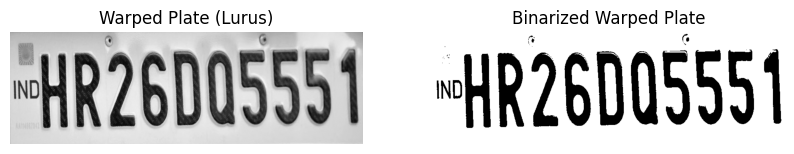


--- HASIL OCR SETELAH WARPING ---
Teks Plat Nomor Terdeteksi: HR26005551


In [169]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- ASUMSI: plate_cnt dan img_rgb sudah tersedia dari kode sebelumnya ---

def four_point_transform(image, pts):
    """
    Melakukan perspektif transformasi pada gambar menggunakan 4 titik.
    
    Args:
        image (np.array): Gambar sumber (plat nomor yang di-crop).
        pts (np.array): 4 titik sudut dari kontur (approx).
    
    Returns:
        np.array: Gambar yang telah diluruskan (warped).
    """
    # Mengurutkan 4 titik kontur agar selalu dalam urutan:
    # Top-Left, Top-Right, Bottom-Right, Bottom-Left
    # Ini penting agar transformasi konsisten.
    
    # Mereshape dari (4, 1, 2) menjadi (4, 2)
    rect = pts.reshape(4, 2)
    
    # Mengurutkan titik berdasarkan koordinat (algoritma sederhana)
    s = rect.sum(axis=1)
    diff = np.diff(rect, axis=1)
    
    tl = rect[np.argmin(s)]       # Top-Left (jumlah terkecil)
    br = rect[np.argmax(s)]       # Bottom-Right (jumlah terbesar)
    tr = rect[np.argmin(diff)]    # Top-Right (selisih X-Y terkecil)
    bl = rect[np.argmax(diff)]    # Bottom-Left (selisih X-Y terbesar)
    
    # Hitung lebar dan tinggi gambar tujuan (segiempat lurus)
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    
    # 4 titik tujuan (segiempat lurus)
    dst = np.array([
        [0, 0],                            # Top-Left
        [maxWidth - 1, 0],                 # Top-Right
        [maxWidth - 1, maxHeight - 1],     # Bottom-Right
        [0, maxHeight - 1]                 # Bottom-Left
    ], dtype="float32")
    
    # 4 titik sumber (yang sudah diurutkan)
    src = np.array([tl, tr, br, bl], dtype="float32")
    
    # Hitung matriks perspektif
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Terapkan transformasi
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped, maxWidth, maxHeight

# --- Implementasi dalam Alur Anda ---
# Asumsikan Anda telah berhasil mendapatkan kontur 4-sudut (plate_cnt)

if plate_cnt is not None:
    # WARP plat nomor dari gambar RGB (lebih baik) atau Grayscale
    # Untuk kejelasan, kita warp dari gambar grayscale yang sudah di-crop:
    warped_plate, w_width, w_height = four_point_transform(gray, plate_cnt) 
    
    # Sekarang 'warped_plate' adalah gambar plat nomor yang tegak lurus
    
    # 1. Binarisasi pada gambar yang sudah diluruskan
    _, plate_thresh = cv2.threshold(warped_plate, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 2. Opsional: Inversi (Jika teks putih di latar hitam)
    # plate_thresh = cv2.bitwise_not(plate_thresh) 
    
    # 3. Konfigurasi OCR (Gunakan PSM 7 untuk satu baris teks)
    config = '--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    
    # Lakukan OCR
    plate_text = pytesseract.image_to_string(plate_thresh, config=config)
    final_text = "".join(plate_text.split()).strip()
    
    # --- PLOT HASIL WARP ---
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Warped Plate (Lurus)")
    plt.imshow(warped_plate, cmap='gray')
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Binarized Warped Plate")
    plt.imshow(plate_thresh, cmap='gray')
    plt.axis("off")
    plt.show()
    
    print(f"\n--- HASIL OCR SETELAH WARPING ---")
    print(f"Teks Plat Nomor Terdeteksi: {final_text}")

else:
    print("Gagal menemukan kontur plat nomor (tidak ada warping yang dilakukan).")